In [37]:
import numpy as np
import pandas as pd
import nltk
import re

In [38]:
events = pd.read_csv("License_To_Drift.csv")
pd.set_option('display.max_columns',200)

In [39]:
events_working = events[["STATE", "CITY", "US REGION", "MONTH", "DATES", "EVENT NAME", "EVENT TYPE",\
                        "WHAT TO DO?", "EVENT DESC (1 SC)", "GOOD 4 KIDS?", "ADMISSION (FREE/FEE)", "FEE DETAIL"]]
events_working

,STATE,CITY,US REGION,MONTH,DATES,EVENT NAME,EVENT TYPE,WHAT TO DO?,EVENT DESC (1 SC),GOOD 4 KIDS?,ADMISSION (FREE/FEE),FEE DETAIL
0,Illinois,Chicago,Midwest,Oct,Early Oct,Bacon and Beer Classic,NaN,"TASTEBUDS, A&E",Prepare yourself for 100+ draft beers from reg...,NO,FEE,Tickets coming soon!
1,Illinois,Chicago,Midwest,Apr,Late Apr,Cotopaxi Questival,NaN,ACTIVE,The Cotopaxi Questival is a 24-hour adventure ...,YES,FEE,NOT IN 2019
2,Illinois,Schaumburg,Midwest,Jun,Early Jun,Gluten Free and Allergen Friendly Expo,Food Expo,"TASTEBUDS, LEARN",Premier gluten and allergen-free consumer show...,YES,FEE,$15 Adult Day Pass. $25 Adult Weekend Pass (ba...
3,Indiana,Indianapolis,Midwest,May,Mid/Late May,Bacon and Beer Classic,NaN,"TASTEBUDS, A&E",We bring together the best local breweries and...,NO,FEE,Not in 2019.
4,Michigan,Kalamazoo,Midwest,Aug,Late Aug,Bikes and Beers Kalamazoo,NaN,"ACTIVE, A&E",Featuring 15 and 30-mile rides departing from ...,NO,YES,$25 event general (spectator). $40-$50 registr...
...,...,...,...,...,...,...,...,...,...,...,...,...
1926,Wisconsin,Milwaukee,Midwest,Sept,Early Sept,Indian Summer Festival,Native Culture,"LEARN, A&E",The largest celebration of Native culture in t...,YES,FEE,$12 - $15 event general (kids under 12 free 20...
1927,Wisconsin,Somerset,Midwest,May,Mid May,Northern Invasion,Music/Rock,A&E,One of the largest rock fests in the Upper Mid...,NO,FEE,$129.50
1928,Wisconsin,Union Grove,Midwest,Oct,Mid/Late Oct,Great Pumpkin Chuckin Fest,"Pumpkin Catapult, BBQ Competition","A&E, ACTIVE",This 2-day event will feature Pumpkin Chuckin ...,YES,FREE,$0 event general.
1929,Wisconsin,West Salem,Midwest,Sep,Mid Sep,Twisted Maze Run,NaN,ACTIVE,Get Totally Twisted with this incredible CORN-...,YES,FEE,NaN


In [40]:
events_working = events_working.dropna(subset = ["EVENT DESC (1 SC)"])
events_working = events_working.dropna(subset = ["WHAT TO DO?"])
events_working["Alex_targets"] = events_working["WHAT TO DO?"]
events_working['Desc_with_name'] = events_working[['EVENT NAME', 'EVENT DESC (1 SC)']].apply(lambda x: ' '.join(x), axis=1)
events_working = events_working.drop(["EVENT DESC (1 SC)", "WHAT TO DO?"], axis = 1)
events_working = events_working.reset_index().drop("index", axis = 1)

In [41]:
# Preprocessing of text data

# Convert all the string to lower cases
events_working.Desc_with_name = events_working.Desc_with_name.str.lower()

# \S+ means anything that is not an empty space
events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: re.sub('http\S*', '', x))

# \s+ means all empty space (\n, \r, \t)
events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: re.sub('\s+', ' ', x))
events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: re.sub('[^\w\s]', '', x))

In [42]:
# Ignoring words that are too common to be deterministic, adding domain words

from nltk.corpus import stopwords
stop = stopwords.words('english') + ["festival", "event", "festiv", "day", "week", "month", "year", "much"\
                                    "feature", "celebration", "celebrate", "featuring", "featurin", "include", \
                                    "weekend", "event", "featuring", "enjoy", "fest", "cotopaxi", "questival", \
                                    "around", "best", "including", "great", "first", "come", "throughout", "area", \
                                    "festivals", "events", "fairs", "days", "celebrations", "fests", "includes", \
                                    "features", "celebrating", "areas"]

events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda text: " ".join(word for word in text.split() if word not in stop))

In [43]:
# Tokenizes description into list of words

from nltk.tokenize import word_tokenize 

events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: word_tokenize(x))

In [44]:
# Lemmatizes words (ignores pluralization, tenses, etc)

from nltk import WordNetLemmatizer

lemztr = WordNetLemmatizer()
events_working.Desc_with_name = events_working.Desc_with_name.apply(lambda x: ' '.join([lemztr.lemmatize(word) for word in x]))

In [45]:
from textblob import TextBlob
import itertools

In [46]:
# The following cells create helper functions for describing word frequency rates in the corpus of event descriptions

def frame_to_dict (x): 
    all_list = list(x)
    all_dict = {}
    for thing in all_list:
        all_dict[thing] = all_list.count(thing)
    return all_dict

def n_gram_flattener(L): 
    N = []
    for item in L:
        new = "_".join(item)
        N.append(new)
    return N

In [47]:
# Prints amount of unique tokens in the dictionary, and how many times each word appears in corpus

blob = ' '.join(events_working.Desc_with_name)
len(blob)

new_blob = TextBlob(blob).ngrams(1)
new_blob_list = list(new_blob)
unigrams_for_dict = n_gram_flattener(new_blob_list)
new_blob_dict = frame_to_dict(unigrams_for_dict)
print(len(list(new_blob_dict.keys())))
{k: v for k, v in sorted(new_blob_dict.items(), key=lambda item: item[1], reverse = True)}

6634


{'music': 614,
 'food': 559,
 'art': 443,
 'live': 361,
 'craft': 357,
 'beer': 299,
 'show': 249,
 'local': 230,
 'wine': 229,
 'film': 226,
 'activity': 226,
 'vendor': 222,
 'entertainment': 216,
 'fun': 209,
 'family': 201,
 'world': 192,
 'community': 177,
 'new': 164,
 'ride': 163,
 'free': 155,
 'book': 146,
 'dance': 144,
 'yoga': 142,
 'game': 136,
 'experience': 133,
 'race': 132,
 'performance': 126,
 'fair': 124,
 'kid': 122,
 'contest': 121,
 'much': 120,
 'balloon': 120,
 'international': 119,
 'artist': 119,
 'workshop': 118,
 'one': 118,
 'country': 112,
 'winter': 111,
 'culture': 111,
 'parade': 108,
 'annual': 107,
 'city': 100,
 'carnival': 99,
 'largest': 97,
 'american': 94,
 'tasting': 93,
 'join': 93,
 'stage': 92,
 'demonstration': 91,
 'competition': 91,
 'park': 88,
 'class': 87,
 'run': 86,
 'people': 85,
 'variety': 83,
 'also': 83,
 'river': 83,
 'street': 82,
 'bacon': 81,
 'fall': 81,
 'u': 81,
 'hot': 81,
 'showcase': 80,
 'get': 78,
 'state': 78,
 'nat

In [48]:
# helper function to print word frequency across docs by percentage

def word_in_event(word):
    T = []
    F = []
    for i in range(len(events_working.Desc_with_name)): 
        if word in events_working.Desc_with_name[i]: 
            T.append(word in events_working.Desc_with_name[i])
        else:
            F.append(word in events_working.Desc_with_name[i])
    print(f"The word \"{word}\" appears in {round((len(T) / len(events_working.Desc_with_name)) * 100, 1)} % of events.")

In [49]:
# Prints the words that occur more than 300 times overall, and shows the percentage of events they appear in

max_num = 300 #can adjust this to be what you like

for word in new_blob_dict.keys():
    if new_blob_dict[word] > max_num:
        print(word_in_event(word))

The word "music" appears in 31.3 % of events.
None
The word "craft" appears in 18.9 % of events.
None
The word "food" appears in 29.3 % of events.
None
The word "art" appears in 33.8 % of events.
None
The word "live" appears in 20.2 % of events.
None


In [102]:
#distribution of #1 tags

{k: v for k, v in sorted(frame_to_dict(events_working.Alex_targets_top).items(), key=lambda item: item[1], reverse = True)}

{'A&E': 593, 'TASTEBUDS': 420, 'ACTIVE': 417, 'LEARN': 384}

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

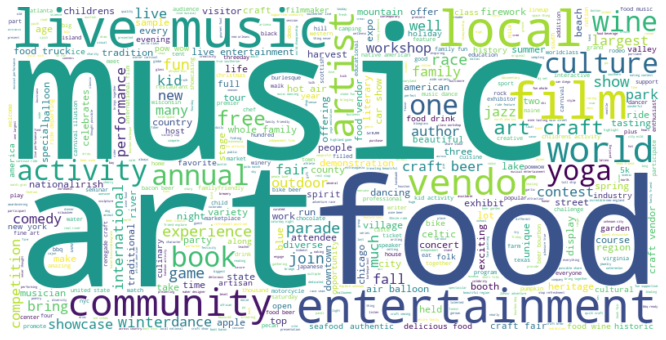

In [50]:
# Generates word cloud of all words in event corpus

wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)

wc.generate(' '.join(events_working.Desc_with_name))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Count Representations of Words

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
# Creates column that only includes first event label in list when multiple are present

events_working.Alex_targets_top = events_working.Alex_targets.apply(lambda x: x.split(',')[0])

C:\Users\matth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
# Processing event descriptions with Count Vectorizer/Bag of words method 

# Includes 1 and 2 word terms, words that appear 7 or more times but in less than 90% of events
count_vec4 = CountVectorizer(ngram_range=(1,2), min_df=7, max_df=.9, max_features=5000)
X_train_count4 = count_vec4.fit_transform(events_working['Desc_with_name'])
X_train_count4.shape

(1814, 1517)

In [670]:
# Running Naive Bayes classifier on bag of words, training on all events but the first 20

multiNB = MultinomialNB()
cntvecMNB = multiNB.fit(X_train_count4[20:,], events_working.Alex_targets_top[20:])

# Testing NB classifier on first 20 events, viewing the predicted label output

new_docs = X_train_count4[:20]
cnt_predicted = cntvecMNB.predict(new_docs)
cnt_predicted

array(['TASTEBUDS', 'ACTIVE', 'TASTEBUDS', 'TASTEBUDS', 'ACTIVE',
       'TASTEBUDS', 'TASTEBUDS', 'ACTIVE', 'TASTEBUDS', 'ACTIVE', 'LEARN',
       'ACTIVE', 'ACTIVE', 'LEARN', 'TASTEBUDS', 'TASTEBUDS', 'ACTIVE',
       'A&E', 'A&E', 'ACTIVE'], dtype='<U9')

In [671]:
# The actual labels Alex assigned for the first 20 events, for comparison

events_working.Alex_targets_top[:20]

0     TASTEBUDS
1        ACTIVE
2     TASTEBUDS
3     TASTEBUDS
4        ACTIVE
5     TASTEBUDS
6     TASTEBUDS
7        ACTIVE
8     TASTEBUDS
9        ACTIVE
10        LEARN
11       ACTIVE
12          A&E
13        LEARN
14    TASTEBUDS
15          A&E
16          A&E
17          A&E
18          A&E
19       ACTIVE
Name: Alex_targets, dtype: object

In [91]:
# Alternative word processing method to plain count vectorizer: TfIdf (penalizing frequent words)

tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=7, max_df=.9, max_features=5000) 
X_train_tf = tf_idf.fit_transform(events_working['Desc_with_name'])

In [94]:
# Fitting NB classifier on new TfIdf word data

tf_idfMNB = multiNB.fit(X_train_tf[20:], events_working.Alex_targets_top[20:])

# Showing predictions for first 20 events

new_docs_tf = X_train_tf[:20]
tfidf_predicted = tf_idfMNB.predict(new_docs_tf)
tfidf_predicted

array(['TASTEBUDS', 'ACTIVE', 'TASTEBUDS', 'TASTEBUDS', 'ACTIVE',
       'TASTEBUDS', 'TASTEBUDS', 'ACTIVE', 'TASTEBUDS', 'ACTIVE', 'LEARN',
       'ACTIVE', 'ACTIVE', 'LEARN', 'TASTEBUDS', 'A&E', 'ACTIVE', 'A&E',
       'A&E', 'ACTIVE', 'A&E', 'ACTIVE', 'A&E', 'A&E', 'TASTEBUDS',
       'ACTIVE', 'A&E', 'TASTEBUDS', 'A&E', 'ACTIVE', 'A&E', 'ACTIVE',
       'A&E', 'TASTEBUDS', 'TASTEBUDS', 'TASTEBUDS', 'TASTEBUDS',
       'ACTIVE', 'A&E', 'A&E', 'A&E', 'ACTIVE', 'ACTIVE', 'ACTIVE',
       'ACTIVE', 'A&E', 'TASTEBUDS', 'ACTIVE', 'A&E', 'ACTIVE', 'A&E',
       'A&E', 'ACTIVE', 'A&E', 'A&E', 'TASTEBUDS', 'LEARN', 'LEARN',
       'A&E', 'LEARN', 'A&E', 'A&E', 'A&E', 'ACTIVE', 'TASTEBUDS', 'A&E',
       'LEARN', 'A&E', 'A&E', 'LEARN', 'TASTEBUDS', 'A&E', 'A&E', 'A&E',
       'ACTIVE', 'TASTEBUDS', 'ACTIVE', 'A&E', 'ACTIVE', 'A&E', 'ACTIVE',
       'LEARN', 'TASTEBUDS', 'ACTIVE', 'A&E', 'ACTIVE', 'A&E', 'ACTIVE',
       'A&E', 'ACTIVE', 'ACTIVE', 'A&E', 'TASTEBUDS', 'LEARN', 'A&E',
       'A

In [96]:
# Printing metric reports for both word count methods
from sklearn import metrics
print('The report for CountVectorizer word embedding through a Multinomial model:')
print(metrics.classification_report(events_working.Alex_targets_top[:20], cnt_predicted, target_names=events_working.Alex_targets_top.unique() ))

The report for CountVectorizer word embedding through a Multinomial model:
              precision    recall  f1-score   support

   TASTEBUDS       0.74      0.65      0.69        65
      ACTIVE       0.80      0.80      0.80        44
       LEARN       0.59      0.74      0.65        23
         A&E       0.76      0.79      0.78        48

    accuracy                           0.73       180
   macro avg       0.72      0.74      0.73       180
weighted avg       0.74      0.73      0.73       180



In [97]:
print('The report for TF-IDF Vectorizer word embedding through a Multinomial model:')
print(metrics.classification_report(events_working.Alex_targets_top[:20], tfidf_predicted, target_names= events_working.Alex_targets_top.unique()))

The report for TF-IDF Vectorizer word embedding through a Multinomial model:
              precision    recall  f1-score   support

   TASTEBUDS       0.73      0.80      0.76        65
      ACTIVE       0.79      0.77      0.78        44
       LEARN       0.77      0.74      0.76        23
         A&E       0.84      0.77      0.80        48

    accuracy                           0.78       180
   macro avg       0.78      0.77      0.78       180
weighted avg       0.78      0.78      0.78       180



## LDA (Latent Dirichlet Allocation)

In [45]:
import gensim

In [46]:
# Processes all but the first event so we can test its categorization afterward

processed_docs  = []

for doc in events_working['Desc_with_name'][1:]:
    doc = doc.split()
    processed_docs.append(doc)
    
processed_docs

[['24hour',
  'adventure',
  'race',
  'team',
  '26',
  'friend',
  'explore',
  'unknown',
  'city',
  'wild',
  'space',
  'thing',
  'never',
  'thought',
  'possible',
  'share',
  'stoke',
  'fun',
  'supportive',
  'community'],
 ['gluten',
  'free',
  'allergen',
  'friendly',
  'expo',
  'premier',
  'gluten',
  'allergenfree',
  'consumer',
  'show',
  'united',
  'state'],
 ['bacon',
  'beer',
  'classic',
  'bring',
  'together',
  'local',
  'brewery',
  'restaurant',
  'stadium',
  'epic',
  'venue',
  'country',
  'ultimate',
  'craft',
  'beer',
  'foodie',
  'biggest',
  'bacon',
  'country',
  'dont',
  'miss',
  'party',
  'roll',
  'town',
  'much',
  'food',
  'beer',
  'thing',
  'life'],
 ['bike',
  'beer',
  'kalamazoo',
  '15',
  '30mile',
  'ride',
  'departing',
  'bell',
  'eccentric',
  'cafe',
  'traveling',
  'beautiful',
  'region',
  'kalamazoo',
  'mi',
  'ride',
  'feature',
  'rest',
  'stop',
  'refreshment',
  'postride'],
 ['bacon',
  'beer',
  'c

In [47]:
# Creating bag of words with indices

dictionary = gensim.corpora.Dictionary(processed_docs)

In [48]:
# Keep words that appear 7 or more times, but in less than 20% of events

dictionary.filter_extremes(no_below=7, no_above=0.2, keep_n=50000)
len(dictionary.keys())

1090

In [49]:
# Shows the first 10 dictionary entries of words in dataset

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 24hour
1 26
2 adventure
3 city
4 community
5 explore
6 friend
7 fun
8 never
9 possible
10 race


In [50]:
# Shows how many times each word appears in specified document
# example: (2,1) means word #2 in the dictionary appears once in this (0th) event

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1)]

In [55]:
from gensim import models
import warnings
warnings.filterwarnings('ignore')
import pyLDAvis.gensim

In [57]:
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(tfidf_corpus, num_topics=6, id2word=dictionary, passes=2, eta=.01)
lda_model_tfidf.save('lda_tfidf_final.model')

In [60]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.030867  0.013230       1        1  22.554585
3      0.011230 -0.050945       2        1  18.441271
4      0.039631 -0.048837       3        1  16.371914
2      0.037850 -0.014595       4        1  14.906528
5      0.013591  0.109849       5        1  14.275867
0     -0.133169 -0.008701       6        1  13.449841, topic_info=     Category        Freq      Term       Total  loglift  logprob
174   Default  192.000000      film  192.000000  30.0000  30.0000
331   Default   96.000000   balloon   96.000000  29.0000  29.0000
1062  Default   35.000000  illusion   35.000000  28.0000  28.0000
90    Default  124.000000      book  124.000000  27.0000  27.0000
121   Default  113.000000      yoga  113.000000  26.0000  26.0000
...       ...         ...       ...         ...      ...      ...
36     Topic6   20.480843     craft  189.569183  -0.2191  -5.2682
225    Topic6   19.178415    family  127.109314   0.1149  -5.3340
256    Topic6   18.566246     world  126.359764   0.0884  -5.3664
41     Topic6   18.779202     local  140.493988  -0.0062  -5.3550
262    Topic6   17.818745  activity  127.186188   0.0408  -5.4075

[415 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
481       1  0.672154   10k
481       2  0.096022   10k
481       6  0.192044   10k
52        1  0.066518    15
52        2  0.099778    15
...     ...       ...   ...
578       1  0.293751  york
578       2  0.106819  york
578       4  0.026705  york
578       5  0.453979  york
578       6  0.106819  york

[1376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 3, 6, 1])

In [ ]:
# topic 1 - outdoor fairs, family / children friendly
# topic 2 - locations /"world", artsy expos, comedy, wine/craft
# topic 3 - local/ethnic culture
# topic 4 - physical and mental wellness - active, but also comedy, literacy
# topic 5 - food parties
# topic 6 - southern cultural

## 1 and 2 both have art as overlap

In [61]:
# Testing first event in dataset to see which clusters the model relates it to, and with how much confidence

unseen_document = events_working["Desc_with_name"][0].split()

bow_vector = dictionary.doc2bow(unseen_document)

for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

Score: 0.973810613155365	 Topic: 0.009*"balloon" + 0.008*"hot" + 0.007*"beer" + 0.007*"bacon" + 0.007*"art"


### Doc2Vec

In [103]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split

In [104]:
X = events_working.Desc_with_name
Y = events_working.Alex_targets_top

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [105]:
# Preprocessing for Doc2Vec model

desc = X_train.str.split()
# desc_test = events_working.Desc_with_name[:20].str.split()
tags = Y_train.str.split()
# tags_test = events_working.Alex_targets_top[:20].str.split()
tags[:10]

1375       [ACTIVE]
1733       [ACTIVE]
1728          [A&E]
183           [A&E]
1423        [LEARN]
103     [TASTEBUDS]
546     [TASTEBUDS]
1651    [TASTEBUDS]
928           [A&E]
482           [A&E]
Name: Alex_targets, dtype: object

In [106]:
docs = [TaggedDocument(d, t) for d, t in zip(desc, tags)]

In [107]:
doc_model = Doc2Vec(docs, dbow_words = 1, vector_size=10, window=7, min_count=2, workers=4)

In [108]:
# Example of new event addition and its label associations

new_vec = doc_model.infer_vector(["Come", "on", "down", "to", "our" "fourth", "of", "july", "fireworks", "festival", \
                            "we", "have", "the", "best", "show", "in", "town", "dozens", "of", "food", "vendors", \
                            "craft", "beer", "live", "music", "and", "games", "and", "tons", "of", "family", \
                            "friendly", "fun"])
doc_model.docvecs.most_similar([new_vec])

[('A&E', 0.875308632850647),
 ('LEARN', 0.8591158390045166),
 ('TASTEBUDS', 0.8507680892944336),
 ('ACTIVE', 0.7870107889175415)]

In [109]:
vec_tests = []
for test in X_test.str.split(): 
    vec_tests.append(doc_model.infer_vector(test))

    
predictions = []
for i in range(len(vec_tests)):
    predictions.append(doc_model.docvecs.most_similar([vec_tests[i]])[0][0])
    
#predictions = np.array(predictions)
predictions

['ACTIVE',
 'LEARN',
 'LEARN',
 'LEARN',
 'LEARN',
 'TASTEBUDS',
 'A&E',
 'ACTIVE',
 'A&E',
 'ACTIVE',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'TASTEBUDS',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'TASTEBUDS',
 'LEARN',
 'A&E',
 'ACTIVE',
 'LEARN',
 'TASTEBUDS',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'ACTIVE',
 'LEARN',
 'A&E',
 'ACTIVE',
 'TASTEBUDS',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'A&E',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'TASTEBUDS',
 'A&E',
 'ACTIVE',
 'TASTEBUDS',
 'ACTIVE',
 'ACTIVE',
 'TASTEBUDS',
 'LEARN',
 'TASTEBUDS',
 'LEARN',
 'A&E',
 'ACTIVE',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'TASTEBUDS',
 'LEARN',
 'A&E',
 'LEARN',
 'A&E',
 'LEARN',
 'LEARN',
 'LEARN',
 'LEARN',
 'A&E',
 'A&E',
 'TASTEBUDS',
 'ACTIVE',
 'A&E',
 'ACTIVE',
 'A&E',
 'A&E',
 'TASTEBUDS',
 'A&E',
 'LEARN',
 'LEARN',
 'LEARN',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'TASTEBUDS',
 'LEARN',
 'ACTIVE',
 'TASTEBUDS',
 'LEARN',
 'A&E',
 'TASTEBUDS',
 'ACTIVE',
 'ACTIVE',
 'TASTEBUDS',
 'ACTIVE',
 'A&

In [110]:
test_array = np.array(Y_test)
len(test_array)

182

In [111]:
from sklearn import metrics
print('The report for Doc2Vec:')
print(metrics.classification_report(test_array, predictions, target_names= events_working.Alex_targets_top.unique()))

The report for Doc2Vec:
              precision    recall  f1-score   support

   TASTEBUDS       0.61      0.43      0.51        53
      ACTIVE       0.55      0.58      0.56        38
       LEARN       0.28      0.54      0.37        35
         A&E       0.70      0.46      0.56        56

    accuracy                           0.49       182
   macro avg       0.54      0.51      0.50       182
weighted avg       0.56      0.49      0.51       182



In [67]:
# Pre-cluster labelling

doc_len_list = list(range(0, len(desc)))
stupid_list = []
for i in range(0, len(doc_len_list)):
    stupid_list.append(str(doc_len_list[i]).split())
#print(type(stupid_list[0]))
len(stupid_list) # amount of entries

1814

In [68]:
cluster_docs = [TaggedDocument(d,s) for d,s in zip(desc, stupid_list)]
doc_model_2 = Doc2Vec(cluster_docs, dbow_words = 1, vector_size=10, window=7, min_count=2, workers=4)

In [71]:
# Shows event entries and how similar it is to new event

doc_model_2.docvecs.most_similar([new_vec])

[('1290', 0.8347976207733154),
 ('507', 0.8268419504165649),
 ('1507', 0.8236880302429199),
 ('582', 0.7999029159545898),
 ('1754', 0.7730684280395508),
 ('1329', 0.7205994725227356),
 ('991', 0.6989998817443848),
 ('1217', 0.6972242593765259),
 ('200', 0.6936211585998535),
 ('1273', 0.6896488666534424)]

In [75]:
cluster_docs[1754]

TaggedDocument(words=['native', 'virginia', 'tech', 'spring', 'pow', 'wow', 'traditional', 'native', 'american'], tags=['1754'])

In [112]:
{k: v for k, v in sorted(frame_to_dict(events_working.Alex_targets_top).items(), key=lambda item: item[1], reverse = True)}

{'A&E': 593, 'TASTEBUDS': 420, 'ACTIVE': 417, 'LEARN': 384}

In [379]:
cross_val_df = events_working[["EVENT NAME", "Desc_with_name"]]

In [380]:
cross_val_df["Alex_targets_top"] = events_working.Alex_targets.apply(lambda x: x.split(',')[0])

C:\Users\matth\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [381]:
#data frame for testing thresholds

cross_val_df

,EVENT NAME,Desc_with_name,Alex_targets_top
0,Bacon and Beer Classic,bacon beer classic prepare 100 draft beer regi...,TASTEBUDS
1,Cotopaxi Questival,24hour adventure race team 26 friend explore u...,ACTIVE
2,Gluten Free and Allergen Friendly Expo,gluten free allergen friendly expo premier glu...,TASTEBUDS
3,Bacon and Beer Classic,bacon beer classic bring together local brewer...,TASTEBUDS
4,Bikes and Beers Kalamazoo,bike beer kalamazoo 15 30mile ride departing b...,ACTIVE
...,...,...,...
1809,Indian Summer Festival,indian summer largest native culture midwest l...,LEARN
1810,Northern Invasion,northern invasion one largest rock upper midwest,A&E
1811,Great Pumpkin Chuckin Fest,pumpkin chuckin 2day feature pumpkin chuckin c...,A&E
1812,Twisted Maze Run,twisted maze run get totally twisted incredibl...,ACTIVE


In [561]:
#general train/test split

A = cross_val_df.Desc_with_name
B = cross_val_df.Alex_targets_top

A_train, A_test, B_train, B_test = train_test_split(A, B, test_size = 0.1, random_state = 0, stratify = B)

In [562]:
#transforming and fitting, count vectorizor for train/test split

count_vec = CountVectorizer(ngram_range=(1,2), min_df=7, max_df=.20, max_features=5000)

A_train_cross = count_vec.fit_transform(A_train)
A_test_cross = count_vec.transform(A_test)

In [563]:
#fitting count vec

cntvecMNB2 = multiNB.fit(A_train_cross, B_train)

In [565]:
#testing count vec

test_cross_docs = A_test_cross
cnt_predicted_2 = cntvecMNB2.predict(test_cross_docs)
cnt_predicted_2

array(['LEARN', 'TASTEBUDS', 'ACTIVE', 'A&E', 'LEARN', 'ACTIVE', 'LEARN',
       'A&E', 'TASTEBUDS', 'A&E', 'A&E', 'TASTEBUDS', 'ACTIVE', 'ACTIVE',
       'TASTEBUDS', 'TASTEBUDS', 'A&E', 'LEARN', 'TASTEBUDS', 'ACTIVE',
       'TASTEBUDS', 'A&E', 'ACTIVE', 'TASTEBUDS', 'TASTEBUDS',
       'TASTEBUDS', 'A&E', 'ACTIVE', 'ACTIVE', 'A&E', 'A&E', 'TASTEBUDS',
       'A&E', 'ACTIVE', 'A&E', 'A&E', 'ACTIVE', 'LEARN', 'TASTEBUDS',
       'A&E', 'ACTIVE', 'A&E', 'LEARN', 'LEARN', 'TASTEBUDS', 'A&E',
       'A&E', 'ACTIVE', 'TASTEBUDS', 'A&E', 'TASTEBUDS', 'A&E', 'A&E',
       'A&E', 'LEARN', 'TASTEBUDS', 'LEARN', 'LEARN', 'A&E', 'ACTIVE',
       'ACTIVE', 'A&E', 'TASTEBUDS', 'TASTEBUDS', 'LEARN', 'ACTIVE',
       'ACTIVE', 'TASTEBUDS', 'A&E', 'ACTIVE', 'A&E', 'ACTIVE',
       'TASTEBUDS', 'ACTIVE', 'A&E', 'A&E', 'A&E', 'TASTEBUDS', 'ACTIVE',
       'TASTEBUDS', 'LEARN', 'ACTIVE', 'ACTIVE', 'A&E', 'TASTEBUDS',
       'LEARN', 'LEARN', 'LEARN', 'ACTIVE', 'A&E', 'A&E', 'A&E', 'ACTIVE',
       'LEA

In [567]:
#putting probabilities on labels, count vec

cnt_predic_list = list(cnt_predicted_2)
cnt_prob_list = []
cnt_prob_array = cntvecMNB2.predict_proba(test_cross_docs)
for i in range(len(cnt_prob_array)):
    cnt_prob_array.sort()
for i in range(len(cnt_prob_array)):
    cnt_prob_list.append(cnt_prob_array[i][-1])

cnt_label_prob = list(zip(cnt_predic_list, cnt_prob_list))

In [568]:
cnt_label_prob

[('LEARN', 0.9906571378674955),
 ('TASTEBUDS', 0.9999999995377209),
 ('ACTIVE', 0.7766263625517151),
 ('A&E', 0.8578569035315019),
 ('LEARN', 0.9875502832161517),
 ('ACTIVE', 0.9954711428570295),
 ('LEARN', 0.714654715926705),
 ('A&E', 0.9821346174821755),
 ('TASTEBUDS', 0.999999611460443),
 ('A&E', 0.994145401227452),
 ('A&E', 0.640827031403506),
 ('TASTEBUDS', 0.9812935710318539),
 ('ACTIVE', 0.787617555609697),
 ('ACTIVE', 0.9917208585314384),
 ('TASTEBUDS', 0.46654014505553176),
 ('TASTEBUDS', 0.999994383710157),
 ('A&E', 0.484390734842584),
 ('LEARN', 0.9750467181375979),
 ('TASTEBUDS', 0.9995130531370618),
 ('ACTIVE', 0.9992125886482391),
 ('TASTEBUDS', 0.6098817157655089),
 ('A&E', 0.9999999963130222),
 ('ACTIVE', 0.9999999643180224),
 ('TASTEBUDS', 0.6425984873496796),
 ('TASTEBUDS', 0.999917350967349),
 ('TASTEBUDS', 0.8674375141248717),
 ('A&E', 0.6211898603530212),
 ('ACTIVE', 0.9999999999998579),
 ('ACTIVE', 0.6781923712336406),
 ('A&E', 0.9999999927079983),
 ('A&E', 0.9999

In [569]:
#accuracy report count vec

print('The report for CountVectorizer word embedding through a Multinomial model:')
print(metrics.classification_report(B_test, cnt_predicted_2, target_names=cross_val_df.Alex_targets_top.unique() ))

The report for CountVectorizer word embedding through a Multinomial model:
              precision    recall  f1-score   support

   TASTEBUDS       0.78      0.73      0.75        59
      ACTIVE       0.73      0.79      0.76        42
       LEARN       0.70      0.67      0.68        39
         A&E       0.73      0.79      0.76        42

    accuracy                           0.74       182
   macro avg       0.74      0.74      0.74       182
weighted avg       0.74      0.74      0.74       182



In [630]:
#transforming train/test to tf-idf

tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=7, max_df=.20, max_features=5000) 

A_train_tf = tf_idf.fit_transform(A_train)
A_test_tf = tf_idf.transform(A_test)

In [631]:
#fitting tf_idf

tf_idfMNB2 = multiNB.fit(A_train_tf, B_train)

In [632]:
#testing tf_idf

new_docs_tf = A_test_tf
tfidf_predicted_2 = tf_idfMNB2.predict(new_docs_tf)
tfidf_predicted_2

array(['LEARN', 'TASTEBUDS', 'ACTIVE', 'A&E', 'LEARN', 'ACTIVE', 'A&E',
       'A&E', 'TASTEBUDS', 'A&E', 'A&E', 'TASTEBUDS', 'ACTIVE', 'ACTIVE',
       'TASTEBUDS', 'TASTEBUDS', 'A&E', 'LEARN', 'TASTEBUDS', 'ACTIVE',
       'A&E', 'A&E', 'ACTIVE', 'A&E', 'TASTEBUDS', 'TASTEBUDS', 'A&E',
       'ACTIVE', 'ACTIVE', 'A&E', 'A&E', 'TASTEBUDS', 'A&E', 'ACTIVE',
       'A&E', 'A&E', 'ACTIVE', 'LEARN', 'TASTEBUDS', 'A&E', 'ACTIVE',
       'A&E', 'LEARN', 'LEARN', 'TASTEBUDS', 'A&E', 'A&E', 'ACTIVE',
       'TASTEBUDS', 'A&E', 'TASTEBUDS', 'A&E', 'A&E', 'A&E', 'LEARN',
       'TASTEBUDS', 'A&E', 'LEARN', 'A&E', 'ACTIVE', 'ACTIVE', 'A&E',
       'TASTEBUDS', 'A&E', 'LEARN', 'ACTIVE', 'ACTIVE', 'TASTEBUDS',
       'A&E', 'ACTIVE', 'A&E', 'ACTIVE', 'TASTEBUDS', 'ACTIVE', 'A&E',
       'A&E', 'A&E', 'TASTEBUDS', 'ACTIVE', 'TASTEBUDS', 'LEARN',
       'ACTIVE', 'ACTIVE', 'A&E', 'TASTEBUDS', 'LEARN', 'LEARN', 'LEARN',
       'ACTIVE', 'A&E', 'A&E', 'A&E', 'ACTIVE', 'LEARN', 'A&E', 'A&E',
       'AC

In [633]:
#mapping top predictions to probabilities

tf_predic_list = list(tfidf_predicted_2)
tf_prob_list = []
tf_prob_array = tf_idfMNB2.predict_proba(new_docs_tf)
for i in range(len(tf_prob_array)):
    tf_prob_array.sort()
for i in range(len(tf_prob_array)):
    tf_prob_list.append(tf_prob_array[i][-1])

tf_label_prob = list(zip(tf_predic_list, tf_prob_list))

In [634]:
tf_label_prob

[('LEARN', 0.4264308162748357),
 ('TASTEBUDS', 0.7881584903553427),
 ('ACTIVE', 0.33768817608489965),
 ('A&E', 0.42729031996829564),
 ('LEARN', 0.52133009730209),
 ('ACTIVE', 0.6059196657249979),
 ('A&E', 0.2992133821518338),
 ('A&E', 0.5986399958108969),
 ('TASTEBUDS', 0.8016509368058744),
 ('A&E', 0.5154436287284747),
 ('A&E', 0.40069408100945125),
 ('TASTEBUDS', 0.5291612905474201),
 ('ACTIVE', 0.425472584024984),
 ('ACTIVE', 0.561192447346115),
 ('TASTEBUDS', 0.31091824739768414),
 ('TASTEBUDS', 0.7814867508566963),
 ('A&E', 0.40122691181737163),
 ('LEARN', 0.4627582865921136),
 ('TASTEBUDS', 0.7347731740474824),
 ('ACTIVE', 0.6764645903710754),
 ('A&E', 0.3478198049118461),
 ('A&E', 0.9193929457589366),
 ('ACTIVE', 0.8065646378229833),
 ('A&E', 0.3778888074780309),
 ('TASTEBUDS', 0.6395369330381518),
 ('TASTEBUDS', 0.5108553078078225),
 ('A&E', 0.4086300934077586),
 ('ACTIVE', 0.8156170316457819),
 ('ACTIVE', 0.33870054686394274),
 ('A&E', 0.9312633611570164),
 ('A&E', 0.865004119

In [635]:
#accuracy report, tf-idf

print('The report for TF-IDF Vectorizer word embedding through a Multinomial model:')
print(metrics.classification_report(B_test_tf, tfidf_predicted_2, target_names= cross_val_df.Alex_targets_top.unique()))

The report for TF-IDF Vectorizer word embedding through a Multinomial model:
              precision    recall  f1-score   support

   TASTEBUDS       0.69      0.81      0.74        59
      ACTIVE       0.74      0.74      0.74        42
       LEARN       0.83      0.64      0.72        39
         A&E       0.78      0.74      0.76        42

    accuracy                           0.74       182
   macro avg       0.76      0.73      0.74       182
weighted avg       0.75      0.74      0.74       182



In [471]:
#train test for doc_to_vec

A_doc = events_working.Desc_with_name
B_doc = events_working.Alex_targets_top

A_train_doc, A_test_doc, B_train_doc, B_test_doc = train_test_split(A_doc, B_doc, test_size=0.1, random_state = 0, stratify = B)

In [403]:
#pre-proc, doc to vec

desc = A_train_doc.str.split()
tags = B_train_doc.str.split()
tags[:10]

769           [A&E]
1418    [TASTEBUDS]
992     [TASTEBUDS]
1406          [A&E]
1378        [LEARN]
411         [LEARN]
1032          [A&E]
921           [A&E]
1191          [A&E]
278         [LEARN]
Name: Alex_targets_top, dtype: object

In [405]:
# pre_proc and training

docs_3 = [TaggedDocument(d, t) for d, t in zip(desc, tags)]
doc_model_3 = Doc2Vec(docs_3, dbow_words = 1, vector_size=10, window=5, min_count=2, workers=4)

In [406]:
# generating list of predictions

vec_tests = []
for test in A_test_doc.str.split(): 
    vec_tests.append(doc_model_3.infer_vector(test))

    
predictions = []
for i in range(len(vec_tests)):
    predictions.append(doc_model_3.docvecs.most_similar([vec_tests[i]])[0][0])
    
#predictions = np.array(predictions)
predictions

['LEARN',
 'LEARN',
 'ACTIVE',
 'A&E',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'TASTEBUDS',
 'LEARN',
 'LEARN',
 'TASTEBUDS',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'TASTEBUDS',
 'A&E',
 'LEARN',
 'TASTEBUDS',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'A&E',
 'TASTEBUDS',
 'A&E',
 'LEARN',
 'LEARN',
 'LEARN',
 'LEARN',
 'LEARN',
 'TASTEBUDS',
 'A&E',
 'LEARN',
 'LEARN',
 'A&E',
 'LEARN',
 'LEARN',
 'A&E',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'LEARN',
 'LEARN',
 'A&E',
 'ACTIVE',
 'ACTIVE',
 'TASTEBUDS',
 'A&E',
 'TASTEBUDS',
 'LEARN',
 'LEARN',
 'LEARN',
 'LEARN',
 'TASTEBUDS',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'A&E',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'ACTIVE',
 'TASTEBUDS',
 'LEARN',
 'LEARN',
 'A&E',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'TASTEBUDS',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'LEARN',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'ACTIVE',
 'LEARN',
 'A&E',
 'ACTIVE',
 'ACTIVE',
 'LEARN',
 'LEARN',
 'LEARN',

In [407]:
#tying cosine scores and predictions together

predic_prob_doc = []
for i in range(len(vec_tests)):
    predic_prob_doc.append(doc_model_3.docvecs.most_similar([vec_tests[i]])[0])

In [408]:
predic_prob_doc

[('LEARN', 0.9877267479896545),
 ('LEARN', 0.9871295690536499),
 ('ACTIVE', 0.9460198879241943),
 ('A&E', 0.9701882004737854),
 ('LEARN', 0.9835630059242249),
 ('ACTIVE', 0.9574952125549316),
 ('LEARN', 0.9877681136131287),
 ('LEARN', 0.9737659096717834),
 ('TASTEBUDS', 0.9774302244186401),
 ('LEARN', 0.9970676302909851),
 ('LEARN', 0.9848828315734863),
 ('TASTEBUDS', 0.9752569794654846),
 ('ACTIVE', 0.8595880270004272),
 ('LEARN', 0.9674987196922302),
 ('LEARN', 0.9855770468711853),
 ('TASTEBUDS', 0.9784653782844543),
 ('A&E', 0.8949620127677917),
 ('LEARN', 0.9791009426116943),
 ('TASTEBUDS', 0.9387587904930115),
 ('ACTIVE', 0.9290194511413574),
 ('LEARN', 0.9839917421340942),
 ('LEARN', 0.9774279594421387),
 ('ACTIVE', 0.9897215962409973),
 ('A&E', 0.9007755517959595),
 ('TASTEBUDS', 0.9600127935409546),
 ('A&E', 0.9356984496116638),
 ('LEARN', 0.9705793857574463),
 ('LEARN', 0.9926737546920776),
 ('LEARN', 0.9820557236671448),
 ('LEARN', 0.9835200309753418),
 ('LEARN', 0.9791797995

In [409]:
test_array = np.array(B_test_doc)

In [410]:
#printing accuracy

print('The report for Doc2Vec:')
print(metrics.classification_report(test_array, predictions, target_names= events_working.Alex_targets_top.unique()))

The report for Doc2Vec:
              precision    recall  f1-score   support

   TASTEBUDS       0.64      0.27      0.38        59
      ACTIVE       0.64      0.55      0.59        42
       LEARN       0.31      0.77      0.44        39
         A&E       0.78      0.43      0.55        42

    accuracy                           0.48       182
   macro avg       0.59      0.50      0.49       182
weighted avg       0.60      0.48      0.48       182



In [457]:
#matching cross validation data frame to output of test list in train/test split

test_index_list = list(B_test_doc.index)
cross_val_df_test = pd.DataFrame(cross_val_df["EVENT NAME"][test_index_list])
cross_val_df_test["Desc_with_name"] = cross_val_df.Desc_with_name[test_index_list]
cross_val_df_test["Alex_targets_top"] = cross_val_df.Alex_targets_top[test_index_list]

In [460]:
cross_val_df_test

,EVENT NAME,Desc_with_name,Alex_targets_top
1372,Olde English Faire,olde english faire wandering player perform on...,LEARN
929,Phoenix New Times Tacolandia,phoenix new time tacolandia tacolandia feature...,TASTEBUDS
1221,Virginia City Grand Victorian Balls,virginia city grand victorian ball period corr...,A&E
251,Long Island Festival of Trees,long island tree continuous live entertainment...,A&E
171,Newburyport Literary Festival,newburyport literary friday april 26th open fi...,LEARN
...,...,...,...
134,Jacob's Pillow Dance Festival,jacob pillow dance summer 350 free performance...,A&E
235,Well Summit,well summit speaker nationally recognized well...,ACTIVE
297,King Manor Fall Festival,king manor fall play game make corn husk doll ...,A&E
338,Bikes and Beers Hershey,bike beer hershey 15 30 45mile ride departing ...,ACTIVE


In [461]:
#putting the predicted labels and probabilities into seperate lists, to impart into data frame

cnt_predic_label = []
cnt_predic_prob = []
tf_predic_label = []
tf_predic_prob = []
doc_predic_label = []
doc_predic_prob = []

for i in range(len(cnt_label_prob)):
    cnt_predic_label.append(cnt_label_prob[i][0])
for i in range(len(cnt_label_prob)):
    cnt_predic_prob.append(cnt_label_prob[i][1])
for i in range(len(tf_label_prob)):
    tf_predic_label.append(tf_label_prob[i][0])
for i in range(len(tf_label_prob)):
    tf_predic_prob.append(tf_label_prob[i][1])
for i in range(len(predic_prob_doc)):
    doc_predic_label.append(predic_prob_doc[i][0])
for i in range(len(predic_prob_doc)):
    doc_predic_prob.append(predic_prob_doc[i][1])

In [462]:
#imparting lists into data frame columns - now you can see what each model predicted, and the score it got

cross_val_df_test["cross_vec_predic"] = cnt_predic_label
cross_val_df_test["cross_vec_prob"] = cnt_predic_prob
cross_val_df_test["tfidf_predic"] = tf_predic_label
cross_val_df_test["tfidf_prob"] = tf_predic_prob
cross_val_df_test["doc_predic"] = doc_predic_label
cross_val_df_test["doc_prob"] = doc_predic_prob

In [463]:
cross_val_df_test

,EVENT NAME,Desc_with_name,Alex_targets_top,cross_vec_predic,cross_vec_prob,tfidf_predic,tfidf_prob,doc_predic,doc_prob
1372,Olde English Faire,olde english faire wandering player perform on...,LEARN,LEARN,0.981983,LEARN,0.411935,LEARN,0.987727
929,Phoenix New Times Tacolandia,phoenix new time tacolandia tacolandia feature...,TASTEBUDS,TASTEBUDS,1.000000,TASTEBUDS,0.778577,LEARN,0.987130
1221,Virginia City Grand Victorian Balls,virginia city grand victorian ball period corr...,A&E,LEARN,0.567319,A&E,0.301893,ACTIVE,0.946020
251,Long Island Festival of Trees,long island tree continuous live entertainment...,A&E,A&E,0.870020,A&E,0.443956,A&E,0.970188
171,Newburyport Literary Festival,newburyport literary friday april 26th open fi...,LEARN,LEARN,0.969482,LEARN,0.492405,LEARN,0.983563
...,...,...,...,...,...,...,...,...,...
134,Jacob's Pillow Dance Festival,jacob pillow dance summer 350 free performance...,A&E,A&E,0.550278,A&E,0.456504,ACTIVE,0.918075
235,Well Summit,well summit speaker nationally recognized well...,ACTIVE,LEARN,0.749441,LEARN,0.321794,LEARN,0.987649
297,King Manor Fall Festival,king manor fall play game make corn husk doll ...,A&E,TASTEBUDS,0.965156,TASTEBUDS,0.411165,LEARN,0.970214
338,Bikes and Beers Hershey,bike beer hershey 15 30 45mile ride departing ...,ACTIVE,ACTIVE,1.000000,ACTIVE,0.992535,ACTIVE,0.972920


In [672]:
#visual sample of what happens when you classify by threshold - some get returned as "none"

cross_val_df_test["cross_predic_thresh_.7"] = \
[x + "" if y >= .7 else "None" for x, y in cnt_label_prob]

cross_val_df_test["tf_predic_thresh_.7"] = \
[x + "" if y >= .7 else "None" for x, y in tf_label_prob]
cross_val_df_test["doc_predic_thresh_.7"] = \
[x + "" if y >= .7 else "None" for x, y in predic_prob_doc]

In [673]:
cross_val_df_test

,EVENT NAME,Desc_with_name,Alex_targets_top,cross_vec_predic,cross_vec_prob,tfidf_predic,tfidf_prob,doc_predic,doc_prob,cross_predic_thresh_.7,tf_predic_thresh_.7,doc_predic_thresh_.7
1372,Olde English Faire,olde english faire wandering player perform on...,LEARN,LEARN,0.981983,LEARN,0.411935,LEARN,0.987727,LEARN,None,LEARN
929,Phoenix New Times Tacolandia,phoenix new time tacolandia tacolandia feature...,TASTEBUDS,TASTEBUDS,1.000000,TASTEBUDS,0.778577,LEARN,0.987130,TASTEBUDS,TASTEBUDS,LEARN
1221,Virginia City Grand Victorian Balls,virginia city grand victorian ball period corr...,A&E,LEARN,0.567319,A&E,0.301893,ACTIVE,0.946020,ACTIVE,None,ACTIVE
251,Long Island Festival of Trees,long island tree continuous live entertainment...,A&E,A&E,0.870020,A&E,0.443956,A&E,0.970188,A&E,None,A&E
171,Newburyport Literary Festival,newburyport literary friday april 26th open fi...,LEARN,LEARN,0.969482,LEARN,0.492405,LEARN,0.983563,LEARN,None,LEARN
...,...,...,...,...,...,...,...,...,...,...,...,...
134,Jacob's Pillow Dance Festival,jacob pillow dance summer 350 free performance...,A&E,A&E,0.550278,A&E,0.456504,ACTIVE,0.918075,None,None,ACTIVE
235,Well Summit,well summit speaker nationally recognized well...,ACTIVE,LEARN,0.749441,LEARN,0.321794,LEARN,0.987649,None,None,LEARN
297,King Manor Fall Festival,king manor fall play game make corn husk doll ...,A&E,TASTEBUDS,0.965156,TASTEBUDS,0.411165,LEARN,0.970214,TASTEBUDS,None,LEARN
338,Bikes and Beers Hershey,bike beer hershey 15 30 45mile ride departing ...,ACTIVE,ACTIVE,1.000000,ACTIVE,0.992535,ACTIVE,0.972920,ACTIVE,ACTIVE,ACTIVE


In [465]:
from sklearn.model_selection import StratifiedKFold

sk10 = StratifiedKFold(n_splits = 10, shuffle = True)

In [607]:
#helper functions to get output of cross-validated threshold scores

# creates an array ("tally table") of 3 values: [num correct, incorrect, no-guess]
def get_tally_table(decision_vals, yval, yval_map, thres):
    # inner function to return [1,0,0], [0,1,0] or [0,0,1] to count
    # correct, incorrect, or not-above-threshold respectively
    def _hit_or_miss(row):
        pred_val = np.argmax(row[:-1])
        max_val = row[pred_val]
        if max_val >= thres:
            if yval_map[pred_val] == row[-1]:
                # correct
                return [1,0,0]
            else:
                # incorrect
                return [0,1,0]
        else:
            # not above threshold
            return [0,0,1]
    # concatenate yval to the predictions (as last column)
    pred_vs_true = np.concatenate([decision_vals, yval.reshape(-1,1)], axis = 1)
    # apply inner _hit_or_miss function per row
    ret_mat = np.apply_along_axis(_hit_or_miss, 
                                  arr = pred_vs_true, 
                                  axis = 1)
    # return the sum of the columns to count correct, incorrect, and missed
    return np.sum(ret_mat,axis = 0)
    

def create_LTD_metric(threshold_range, model_obj, pre_proc, model_brand = 'sklearn'):
    tally_tables = {}
    if pre_proc == "count_vec":
        X = count_vec.transform(A)
        y = np.array(B)
        Xtrain = A_train_cross
        ytrain = B_train
    if pre_proc == "tfidf":
        X = tf_idf.transform(A)
        y = np.array(B)
        Xtrain = A_train_tf
        ytrain = B_train
    if pre_proc == "doc2vec":
        X = A_doc
        y = np.array(B_doc)
        Xtrain = A_train_doc
        ytrain = B_train_doc
    for thres in threshold_range:
        tally_tables[thres] = []
#         probas_top = []
        for tr_idx, val_idx in sk10.split(Xtrain,ytrain):
            Xtr, Xval = X[tr_idx], X[val_idx]
            ytr, yval = y[tr_idx], y[val_idx]
            if model_brand == 'sklearn':
                model_obj.fit(Xtr,ytr)
                probas = model_obj.predict_proba(Xval)
                yval_map = {idx:label for idx, label in enumerate(model_obj.classes_)}
                tally_tables[thres].append(get_tally_table(probas,yval, yval_map, thres))
            if model_brand == 'gensim':
                #model_obj.fit(Xtr,ytr)
                #cos_sims = blah #model_obj.predict_proba(Xval)
                tally_tables[thres].append(get_tally_table(cos_sims,yval,thres))
#    return yval
    return {thres:np.mean(tally_tables[thres], axis = 0) for thres in threshold_range}

In [625]:
#raw output, cross validation on threshold

create_LTD_metric( np.linspace(0.01, 0.99, 99), tf_idfMNB2, "tfidf", 'sklearn' )

{0.01: array([123.5,  39.7,   0. ]),
 0.02: array([124.1,  39.1,   0. ]),
 0.03: array([124.4,  38.8,   0. ]),
 0.04: array([124.7,  38.5,   0. ]),
 0.05: array([125. ,  38.2,   0. ]),
 0.060000000000000005: array([125. ,  38.2,   0. ]),
 0.06999999999999999: array([124.5,  38.7,   0. ]),
 0.08: array([124.8,  38.4,   0. ]),
 0.09: array([124.5,  38.7,   0. ]),
 0.09999999999999999: array([123.8,  39.4,   0. ]),
 0.11: array([124.6,  38.6,   0. ]),
 0.12: array([123.7,  39.5,   0. ]),
 0.13: array([124.4,  38.8,   0. ]),
 0.14: array([124.6,  38.6,   0. ]),
 0.15000000000000002: array([123.6,  39.6,   0. ]),
 0.16: array([124.6,  38.6,   0. ]),
 0.17: array([124.8,  38.4,   0. ]),
 0.18000000000000002: array([124.6,  38.6,   0. ]),
 0.19: array([124.5,  38.7,   0. ]),
 0.2: array([124.3,  38.9,   0. ]),
 0.21000000000000002: array([124.8,  38.4,   0. ]),
 0.22: array([125.6,  37.6,   0. ]),
 0.23: array([124. ,  39.2,   0. ]),
 0.24000000000000002: array([124.6,  38.6,   0. ]),
 0.25: 

In [674]:
#data_frame, TFIDF model cross validated

d = create_LTD_metric(np.linspace(0.01, 0.99, 99), tf_idfMNB2, "tfidf", 'sklearn' )
model_thresh_tfidf_df = pd.DataFrame(np.vstack(d.values()), 
             index = d.keys(), 
             columns = ['correct','incorrect','no guess'] )
model_thresh_tfidf_df

,correct,incorrect,no guess
0.01,124.7,38.5,0.0
0.02,125.0,38.2,0.0
0.03,124.7,38.5,0.0
0.04,123.7,39.5,0.0
0.05,124.1,39.1,0.0
...,...,...,...
0.95,12.4,0.0,150.8
0.96,11.0,0.0,152.2
0.97,8.6,0.0,154.6
0.98,5.6,0.0,157.6


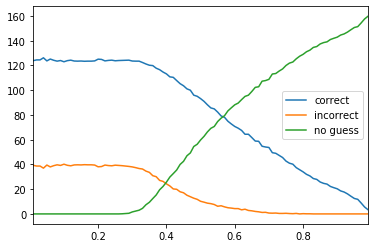

In [637]:
#graph of data frame

model_thresh_tfidf_df.plot()

In [675]:
#data frame, cross vectorization cross validated

e = create_LTD_metric(np.linspace(0.01, 0.99, 99), cntvecMNB2, "count_vec", 'sklearn' )
model_thresh_cvec_df = pd.DataFrame(np.vstack(e.values()), 
             index = e.keys(), 
             columns = ['correct','incorrect','no guess'] )
model_thresh_cvec_df

,correct,incorrect,no guess
0.01,126.4,36.8,0.0
0.02,125.5,37.7,0.0
0.03,125.9,37.3,0.0
0.04,126.9,36.3,0.0
0.05,126.8,36.4,0.0
...,...,...,...
0.95,97.1,13.6,52.5
0.96,94.7,11.6,56.9
0.97,92.5,11.4,59.3
0.98,88.2,10.5,64.5


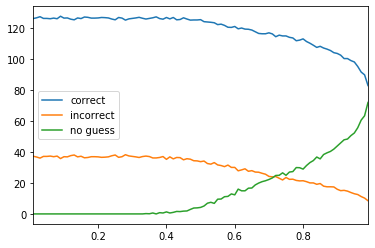

In [639]:
#visual of DF

model_thresh_cvec_df.plot()